## OVERVIEW
---
* Exploratory Data Analysis
    * Univariate & Bivariate Analysis
    * AutoCorrelation Functions
    * Etc...
* Feature Engineering
* Predictive Modelling
    * ARIMA Model
    * XGBoost With Bayesian Optimization
* Metrics Comparison of Predictive Models
* Monte Carlo Simulation

In [2]:
#VIZ AND DATA MANIPULATION LIBRARY
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

from plotly import tools
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


#Preprocessing
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform

#MODELS
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization


#CLASSICAL STATS
import scipy
import statsmodels
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from fbprophet import Prophet
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.seasonal import seasonal_decompose


#DEEP LEARNING LIB
from keras.models import Model,Sequential
from keras.utils import np_utils, to_categorical
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.utils import plot_model
import itertools
import lightgbm as lgb



#METRICS
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, r2_score,mean_absolute_error,mean_squared_error

from random import randrange
import warnings 
warnings.filterwarnings('ignore')

#### READ THE DATA

In [3]:
df = pd.read_csv('../input/foreign-exchange-rates-per-dollar-20002019/Foreign_Exchange_Rates.csv')
print('DATASET SHAPE: ', df.shape)
df.head()

DATASET SHAPE:  (5217, 24)


,Unnamed: 0,Time Serie,AUSTRALIA - AUSTRALIAN DOLLAR/US$,EURO AREA - EURO/US$,NEW ZEALAND - NEW ZELAND DOLLAR/US$,UNITED KINGDOM - UNITED KINGDOM POUND/US$,BRAZIL - REAL/US$,CANADA - CANADIAN DOLLAR/US$,CHINA - YUAN/US$,HONG KONG - HONG KONG DOLLAR/US$,...,SINGAPORE - SINGAPORE DOLLAR/US$,DENMARK - DANISH KRONE/US$,JAPAN - YEN/US$,MALAYSIA - RINGGIT/US$,NORWAY - NORWEGIAN KRONE/US$,SWEDEN - KRONA/US$,SRI LANKA - SRI LANKAN RUPEE/US$,SWITZERLAND - FRANC/US$,TAIWAN - NEW TAIWAN DOLLAR/US$,THAILAND - BAHT/US$
0,0,2000-01-03,1.5172,0.9847,1.9033,0.6146,1.805,1.4465,8.2798,7.7765,...,1.6563,7.329,101.7,3.8,7.964,8.443,72.3,1.5808,31.38,36.97
1,1,2000-01-04,1.5239,0.97,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,...,1.6535,7.218,103.09,3.8,7.934,8.36,72.65,1.5565,30.6,37.13
2,2,2000-01-05,1.5267,0.9676,1.9339,0.6092,1.856,1.4518,8.2798,7.778,...,1.656,7.208,103.77,3.8,7.935,8.353,72.95,1.5526,30.8,37.1
3,3,2000-01-06,1.5291,0.9686,1.9436,0.607,1.84,1.4571,8.2797,7.7785,...,1.6655,7.2125,105.19,3.8,7.94,8.3675,72.95,1.554,31.75,37.62
4,4,2000-01-07,1.5272,0.9714,1.938,0.6104,1.831,1.4505,8.2794,7.7783,...,1.6625,7.2285,105.17,3.8,7.966,8.415,73.15,1.5623,30.85,37.3


In [4]:
#show columns
df.columns = [col.lower() for col in df.columns]
df['time serie'] = pd.to_datetime(df['time serie'])
df.columns

Index(['unnamed: 0', 'time serie', 'australia - australian dollar/us$',
       'euro area - euro/us$', 'new zealand - new zeland dollar/us$',
       'united kingdom - united kingdom pound/us$', 'brazil - real/us$',
       'canada - canadian dollar/us$', 'china - yuan/us$',
       'hong kong - hong kong dollar/us$', 'india - indian rupee/us$',
       'korea - won/us$', 'mexico - mexican peso/us$',
       'south africa - rand/us$', 'singapore - singapore dollar/us$',
       'denmark - danish krone/us$', 'japan - yen/us$',
       'malaysia - ringgit/us$', 'norway - norwegian krone/us$',
       'sweden - krona/us$', 'sri lanka - sri lankan rupee/us$',
       'switzerland - franc/us$', 'taiwan - new taiwan dollar/us$',
       'thailand - baht/us$'],
      dtype='object')

In [5]:
#get the date and rates of singapore dollar
data = df[['time serie', 'singapore - singapore dollar/us$']]
data.columns = ['date', 'rate']

In [6]:
#show new dataframe
data.head()

,date,rate
0,2000-01-03,1.6563
1,2000-01-04,1.6535
2,2000-01-05,1.656
3,2000-01-06,1.6655
4,2000-01-07,1.6625


## EDA
---

In [7]:
#show feature data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5217 entries, 0 to 5216
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5217 non-null   datetime64[ns]
 1   rate    5217 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 81.6+ KB


In [8]:
#remove rates with a value of ND
data = data.drop(data[data['rate']=='ND'].index)
#converte the rates to numeric value
data['rate'] = pd.to_numeric(data.rate)
#sort values by date
data = data.sort_values('date', ascending=True)

#### * Note: Never forget to arrange the data by date, because date arrangement is very important when it comes to forecasting.

In [9]:
#show basic stats
data.rate.describe()

count    5019.000000
mean        1.480398
std         0.188932
min         1.200700
25%         1.342950
50%         1.408500
75%         1.679150
max         1.854000
Name: rate, dtype: float64

### DATA DISTRIBUTION

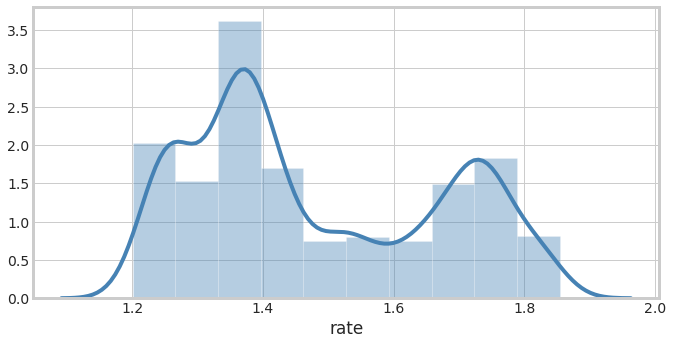

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(data.rate, bins=10, color='steelblue');

### TIME-SERIES PLOT

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.date, y=data.rate, marker_color='lightgreen'))

fig.update_layout(title='TIME-SERIES PLOT OF SINGAPORE DOLLAR RATE', 
                  height=450, width=1000, template='plotly_dark', font_color='lightgreen', 
                  font=dict(family="sans serif",
                            size=16,
                            color="grey"
                            ))

fig.update_xaxes(title='Date')
fig.update_yaxes(title='Rate / $')
fig.show()

### AUTO CORRELATION FUNCTION PLOT

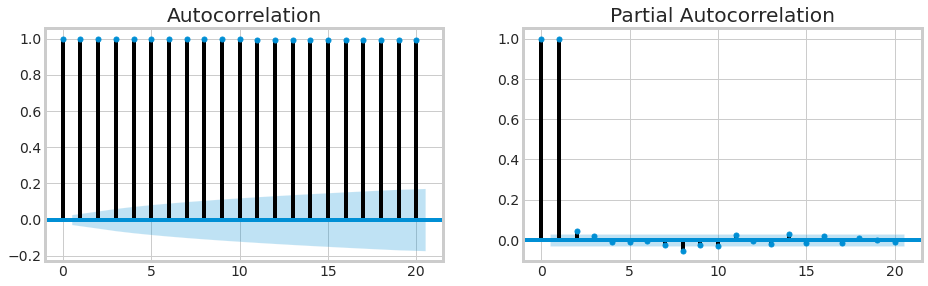

In [12]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
plot_acf(data.rate, lags=20, ax=ax[0]);
plot_pacf(data.rate, lags=20, ax=ax[1]);

* The autocorrelation function shows a very slow decay, which means that the future values have a very high correlation with its past values.

* The partial autocorrelation function shows a high correlation with the first lag and lesser correlation with the second and third lag.

### SEASONAL DECOMPOSITION

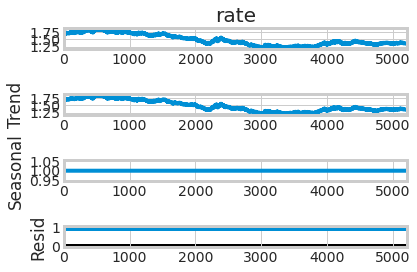

In [13]:
sdec = seasonal_decompose(data.rate, model='multiplicative', freq=1)
sdec.plot();

* We can see that the residual plot shows zero. The decomposition was not able to separate the noise that we added from the linear trend.

## FORECASTING SECTION
---

* GET THE LAST 30 DAYS DATA FOR MODEL VALIDATION


In [14]:

X_train, X_val = data[:-30], data[-30:]

print('X_train Shape: ', X_train.shape)
print('X_val Shape: ', X_val.shape)

X_train Shape:  (4989, 2)
X_val Shape:  (30, 2)


### ARIMA (Auto Regressive Integrated Moving Average)

In [74]:
predictions = []

arima = sm.tsa.statespace.SARIMAX(X_train.rate,order=(1,1,1),seasonal_order=(1,1,1,6),
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
#get a 30 days prediction
predictions.append(arima.forecast(30))
#converting and reshaping 
predictions = np.array(predictions).reshape((30,))

#### ARIMA SUMMARY

In [76]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              rate   No. Observations:                 4989
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood               18827.711
Date:                           Wed, 15 Jul 2020   AIC                         -37645.422
Time:                                   13:33:17   BIC                         -37612.862
Sample:                                        0   HQIC                        -37634.007
                                          - 4989                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4707      0.248      1.900      0.057      -0.015       0.956
ma.L1         -0.5224      0.238     -2.199      0.028      -0.988      -0.057
ar.S.L6       -0.0336      0.026     -1.313      0.189      -0.084       0.017
ma.S.L6       -0.6997      0.023    -30.674      0.000      -0.744      -0.655
sigma2      4.552e-05   8.87e-07     51.296      0.000    4.38e-05    4.73e-05
===================================================================================
Ljung-Box (Q):                      251.68   Jarque-Bera (JB):              3431.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

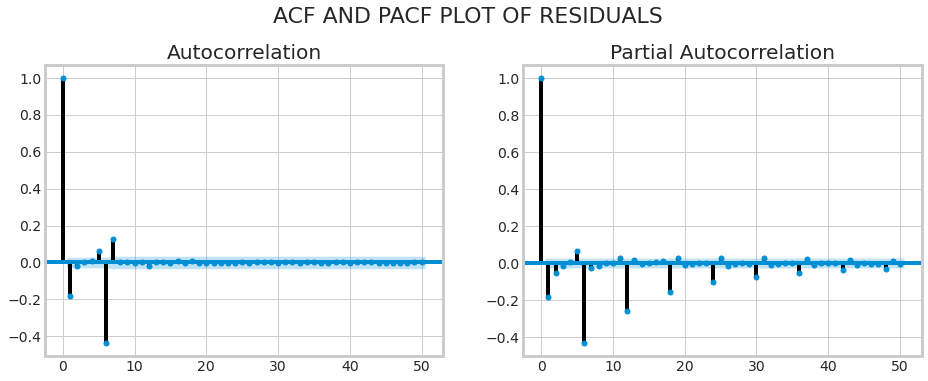

In [86]:
res = arima.resid
fig,ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('ACF AND PACF PLOT OF RESIDUALS', fontsize=22, x=0.5, y=1.04)
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

#### COMPARISON OF TRUE VALUE AND ARIMA PREDICTIONS

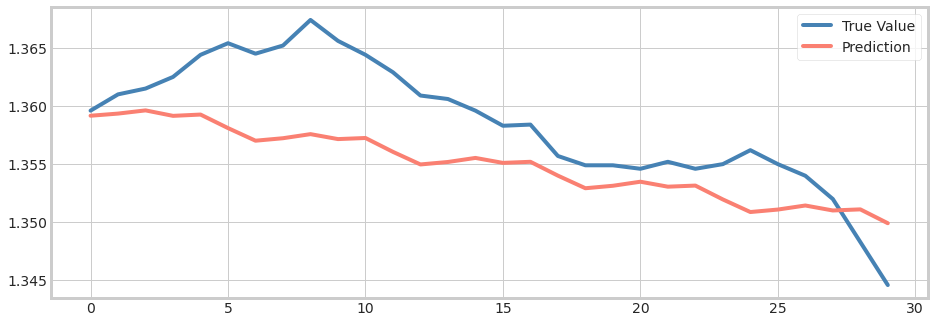

In [91]:
y_val = data.rate[-30:]
plt.figure(figsize=(14,5))
plt.plot(np.arange(len(y_val)), y_val, color='steelblue');
plt.plot(np.arange(len(y_val)), predictions, color='salmon');
plt.legend(['True Value', 'Prediction']);


#### MAE, MSE, RMSE

In [92]:

arima_mae = mean_absolute_error(y_val, predictions)
arima_mse = mean_squared_error(y_val, predictions)
arima_rmse = np.sqrt(mean_squared_error(y_val, predictions))

print('Mean Absolute Error:   ', arima_mae)
print('Mean Squared Error:   ', arima_mse)
print('Root Mean Squared Error:   ', arima_rmse)

Mean Absolute Error:    0.004111282993100721
Mean Squared Error:    2.3279996125657114e-05
Root Mean Squared Error:    0.004824934831234212


#### MEAN ABSOLUTE PERCENTAGE ERROR

In [94]:
arima_error_rate = abs(((y_val - predictions) / y_val).mean()) * 100
print('MAPE:', round(arima_error_rate,2), '%')

MAPE: 0.26 %


#### R-SQUARED SCORE

In [95]:
print('R2-SCORE: ', r2_score(y_val, predictions))

R2-SCORE:  0.18357690506190794


### XGBOOST

#### Feature Engineering

In [106]:
#extract the date feature
data['day'] = data.date.dt.day
data['dayofweek'] = data.date.dt.dayofweek
data['dayofyear'] = data.date.dt.dayofyear
data['week'] = data.date.dt.week
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year

In [118]:
#add lag feature
for i in range(1,8):
    data['lag'+str(i)] = data.rate.shift(i).fillna(0)

In [122]:
#drop the date feature
data.drop('date', axis=1, inplace=True)
#show new data frame
data.head(7)

,rate,day,dayofweek,week,month,year,dayofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,1.6563,3,0,1,1,2000,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
1,1.6535,4,1,1,1,2000,4,1.6563,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
2,1.6560,5,2,1,1,2000,5,1.6535,1.6563,0.0000,0.0000,0.0000,0.0000,0.0
3,1.6655,6,3,1,1,2000,6,1.6560,1.6535,1.6563,0.0000,0.0000,0.0000,0.0
4,1.6625,7,4,1,1,2000,7,1.6655,1.6560,1.6535,1.6563,0.0000,0.0000,0.0
5,1.6618,10,0,2,1,2000,10,1.6625,1.6655,1.6560,1.6535,1.6563,0.0000,0.0
6,1.6690,11,1,2,1,2000,11,1.6618,1.6625,1.6655,1.6560,1.6535,1.6563,0.0


#### SPLIT THE DATA

In [123]:
X = data.drop('rate', axis=1)
y = data.rate

X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (4989, 13)
y_train:  (4989,)
X_test:  (30, 13)
y_test:  (30,)


In [124]:
#convert data to xgb matrix form
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test)

#### XGBOOST BAYESIAN OPTIMIZATION

In [125]:
#bayesian hyper parameter tuning
#define the params
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    
    cv_result = xgb.cv(params, dtrain, num_boost_round=250, nfold=3)    
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [126]:
#run optimizer
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
#define iter points
xgb_bo.maximize(init_points=10, n_iter=15, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        | -0.02602  |  0.7551   |  0.8157   |  6.66     |
|  2        | -0.01457  |  0.6419   |  0.1777   |  5.542    |
|  3        | -0.01172  |  0.5695   |  0.08324  |  3.256    |
|  4        | -0.01833  |  0.84     |  0.3361   |  4.313    |
|  5        | -0.02813  |  0.4344   |  0.9509   |  5.074    |
|  6        | -0.01503  |  0.7984   |  0.187    |  5.947    |
|  7        | -0.02606  |  0.5663   |  0.8167   |  4.374    |
|  8        | -0.02099  |  0.5315   |  0.5072   |  3.541    |
|  9        | -0.0152   |  0.5961   |  0.1975   |  5.623    |
|  10       | -0.01731  |  0.4475   |  0.2625   |  5.472    |
|  11       | -0.00737  |  0.6915   |  0.0      |  3.0      |
|  12       | -0.01108  |  0.8648   |  0.07145  |  3.113    |
|  13       | -0.007777 |  0.4787   |  0.003552 |  3.002    |
|  14       | -0.008297 |  0.615    |  0.009363 |  3.007    |
|  15   

In [135]:

#get the best parameters
params = xgb_bo.max['params']
params['max_depth'] = int(round(params['max_depth']))
#train the data
model = xgb.train(params, dtrain, num_boost_round=200)

In [136]:
#predict the test data 
predictions = model.predict(dtest)

#### COMPARISON OF TRUE VALUE AND XGBOOST PRODECTIONS

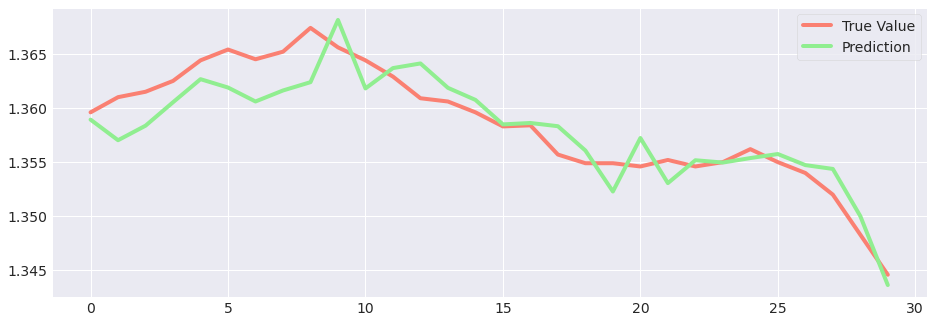

In [142]:
y_val = data.rate[-30:]
plt.figure(figsize=(14,5))
sns.set_style('darkgrid')
plt.plot(np.arange(len(y_val)), y_val, color='salmon');
plt.plot(np.arange(len(y_val)), predictions, color='lightgreen');
plt.legend(['True Value', 'Prediction']);


#### MAE, MSE ,RMSE

In [143]:
xgb_mae = mean_absolute_error(y_val, predictions)
xgb_mse = mean_squared_error(y_val, predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_val, predictions))

print('Mean Absolute Error:   ', xgb_mae)
print('Mean Squared Error:   ', xgb_mse)
print('Root Mean Squared Error:   ', xgb_rmse)

Mean Absolute Error:    0.001951851094563802
Mean Squared Error:    5.455547970530412e-06
Root Mean Squared Error:    0.0023357114484735507


#### MEAN ABSOLUTE PERCENTAGE ERROR

In [144]:
xgb_error_rate = abs(((y_val - predictions) / y_val).mean()) * 100
print('MAPE:', round(xgb_error_rate,2), '%')

MAPE: 0.04 %


#### R-SQUARED SCORE

In [146]:
print('R2-SCORE: ', r2_score(y_val, predictions))

R2-SCORE:  0.8086754252602805


### MONTE CARLO SIMULATION

In [168]:

#function that can generate a monte carlo simulation    
def monte_carlo_simulation(data,t_intervals ,iteration , figsize = (10,4), lw=1):
    from scipy.stats import norm

    #log returns of data
    log_returns = np.log(1 + data.pct_change())

    #Setting up the drift and random component
    mean_  = log_returns.mean()
    var = log_returns.var()
    stdev = log_returns.std()
    drift = mean_ - (0.5 *var)

    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iteration)))

    S0 = data.iloc[-1]
    #Empty daily returns
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0

    #appliying montecarlo simulation
    for i in range(1 , t_intervals):
        price_list[i] = price_list[i-1] * daily_returns[i]
    fig_title = str(t_intervals)+ ' DAYS SIMULATION WITH ' +str(iteration)+' DIFFERENT POSSIBILITIES'
    #Show the result of 30 days simulation
    plt.figure(figsize=figsize)
    plt.plot(price_list, lw=lw)
    plt.title(fig_title)
    plt.xlabel('Interval', fontsize=16)
    plt.ylabel('Value', fontsize=16)

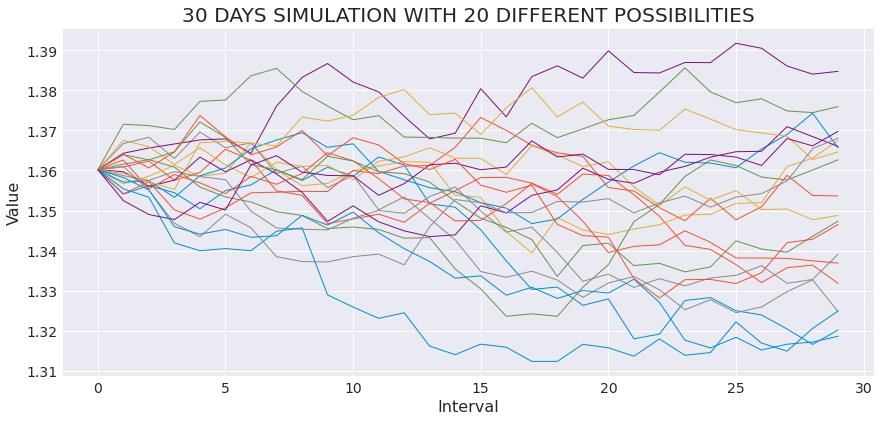

In [172]:
#fit the X_train and show the figure
monte_carlo_simulation(y_train,30,20, figsize=(13,6))